In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = "/fast/nchandak/qaevals/judge_outputs/mmlu_pro_free/random_sample/"
OUTPUT_DIR = "/fast/nchandak/qaevals/judge_outputs/mmlu_pro_free/stratified_sample/"

In [2]:
# Load the samples files recursively and calculate accuracy for each model
import os
import json
from pathlib import Path

model_accuracies = {}

# Walk through all files in the output directory recursively
for root, dirs, files in os.walk(OUTPUT_DIR):
    if "samples.json" in files:
        # Load the samples file
        samples_path = os.path.join(root, "samples.json")
        
        # Extract model name from the path (last folder name)
        model_name = os.path.basename(root)
        
        try:
            with open(samples_path, 'r') as f:
                samples_data = json.load(f)
            
            # Count correct answers using score_deepseek-chat-v3-0324 field
            score_field = "score_deepseek-chat-v3-0324"
            thinking_finished = "thinking_finished"
            
            correct_count = sum(1 for item in samples_data if item.get(score_field) == "1")
            total_count = sum(1 for item in samples_data if score_field in item)
            think_over = sum(1 for item in samples_data if item.get(thinking_finished))
            
            if total_count > 0:
                accuracy = (correct_count / total_count) * 100
                model_accuracies[model_name] = {'accuracy': accuracy, 'thinking_finished': think_over}
                print(f"Model: {model_name}, Accuracy: {correct_count}/{total_count} ({accuracy:.2f}%)")
            else:
                print(f"No valid scores found for model: {model_name}")
        
        except Exception as e:
            print(f"Error processing {samples_path}: {e}")

# Print overall results
print("\nModel Accuracies:")
for model, value in sorted(model_accuracies.items()):
    print(f"{model}: {value['accuracy']:.2f}%")

# Convert to DataFrame for easier analysis
model_acc_df = pd.DataFrame({
    'Model': list(model_accuracies.keys()),
    'Accuracy (%)': [model_accuracies[model]['accuracy'] for model in model_accuracies.keys()],
    'Thinking Finished': [model_accuracies[model]['thinking_finished'] for model in model_accuracies.keys()]
})

# Sort by accuracy for better visualization
model_acc_df = model_acc_df.sort_values('Accuracy (%)', ascending=False)
model_acc_df


Model: Qwen3-8B_thinking, Accuracy: 504/1002 (50.30%)
Model: Qwen3-14B_non_thinking, Accuracy: 541/1002 (53.99%)
Model: Qwen3-4B_thinking, Accuracy: 492/1002 (49.10%)
Model: Qwen3-1.7B_non_thinking, Accuracy: 293/1002 (29.24%)
Model: Qwen3-8B_non_thinking, Accuracy: 487/1002 (48.60%)
Model: Qwen3-1.7B_thinking, Accuracy: 420/1002 (41.92%)
Model: Qwen3-4B_non_thinking, Accuracy: 442/1002 (44.11%)
Model: Qwen3-14B_thinking, Accuracy: 570/1002 (56.89%)
Model: Qwen3-0.6B_non_thinking, Accuracy: 65/1002 (6.49%)
Model: Qwen3-32B_thinking, Accuracy: 512/1002 (51.10%)
Model: Qwen3-32B_non_thinking, Accuracy: 550/1002 (54.89%)
Model: Qwen3-0.6B_thinking, Accuracy: 138/1002 (13.77%)

Model Accuracies:
Qwen3-0.6B_non_thinking: 6.49%
Qwen3-0.6B_thinking: 13.77%
Qwen3-1.7B_non_thinking: 29.24%
Qwen3-1.7B_thinking: 41.92%
Qwen3-14B_non_thinking: 53.99%
Qwen3-14B_thinking: 56.89%
Qwen3-32B_non_thinking: 54.89%
Qwen3-32B_thinking: 51.10%
Qwen3-4B_non_thinking: 44.11%
Qwen3-4B_thinking: 49.10%
Qwen3-8B

,Model,Accuracy (%),Thinking Finished
7,Qwen3-14B_thinking,56.886228,989
10,Qwen3-32B_non_thinking,54.890220,1002
1,Qwen3-14B_non_thinking,53.992016,1002
9,Qwen3-32B_thinking,51.097804,998
0,Qwen3-8B_thinking,50.299401,960
2,Qwen3-4B_thinking,49.101796,982
4,Qwen3-8B_non_thinking,48.602794,1002
6,Qwen3-4B_non_thinking,44.111776,1002
5,Qwen3-1.7B_thinking,41.916168,987
3,Qwen3-1.7B_non_thinking,29.241517,1002


<Figure size 1200x800 with 0 Axes>

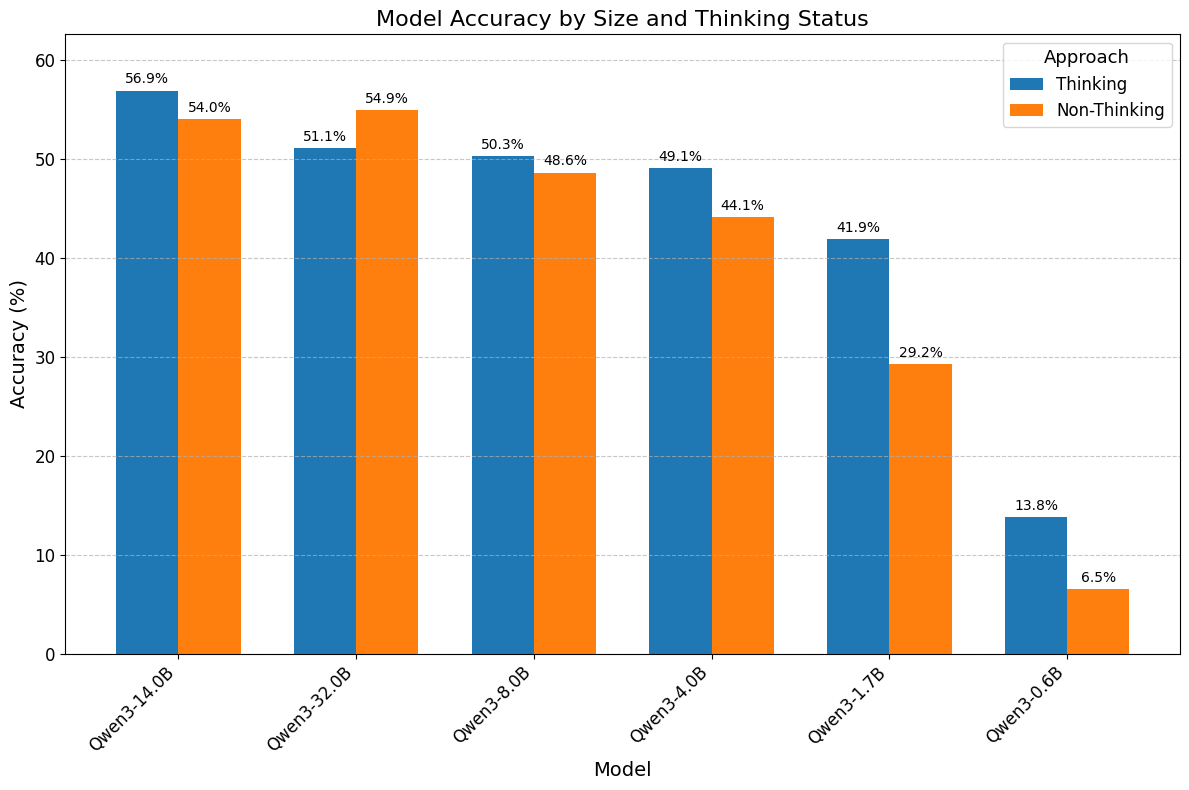

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract model size and base model name from model names
model_sizes = []
thinking_status = []
base_models = []

for model in model_acc_df['Model']:
    # Extract model size (e.g., 0.6B, 1.7B, etc.)
    size_match = re.search(r'Qwen3-(\d+\.?\d*)B', model)
    size = float(size_match.group(1)) if size_match else 0
    model_sizes.append(size)
    
    # Extract thinking status
    thinking = 'Non-Thinking' if 'non_thinking' in model else 'Thinking'
    thinking_status.append(thinking)
    
    # Extract base model name without thinking status
    base_model = f"Qwen3-{size}B" if size > 0 else model
    base_models.append(base_model)

# Add new columns to the DataFrame
model_acc_df['Size (B)'] = model_sizes
model_acc_df['Thinking Status'] = thinking_status
model_acc_df['Base Model'] = base_models

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Define better colors for thinking and non-thinking
colors = {'Thinking': '#1f77b4', 'Non-Thinking': '#ff7f0e'}  # Blue and orange

# Get unique base models and sort them by size
unique_base_models = sorted(model_acc_df['Base Model'].unique(), 
                           key=lambda x: float(re.search(r'(\d+\.?\d*)', x).group(1)) 
                           if re.search(r'(\d+\.?\d*)', x) else 0)

# Set up the x positions
x = np.arange(len(unique_base_models))
width = 0.35  # Width of the bars

# Create grouped bar plot manually
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each thinking status
for i, status in enumerate(['Thinking', 'Non-Thinking']):
    # Filter data for this status
    status_data = model_acc_df[model_acc_df['Thinking Status'] == status]
    
    # Prepare heights for each base model
    heights = []
    for base_model in unique_base_models:
        model_data = status_data[status_data['Base Model'] == base_model]
        if not model_data.empty:
            heights.append(model_data['Accuracy (%)'].values[0])
        else:
            heights.append(0)
    
    # Plot the bars
    offset = width * (i - 0.5)
    bars = ax.bar(x + offset, heights, width, label=status, color=colors[status])
    
    # Add value labels on top of each bar
    for j, bar in enumerate(bars):
        if heights[j] > 0:  # Only add label if bar exists
            ax.annotate(
                f'{heights[j]:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10
            )

# Customize the plot
ax.set_title('Model Accuracy by Size and Thinking Status', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(unique_base_models, rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Approach', fontsize=12, title_fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure y-axis starts from 0
ax.set_ylim(0, max(model_acc_df['Accuracy (%)']) * 1.1)

plt.tight_layout()
plt.show()


# # Create a second plot for unfinished thinking counts
# plt.figure(figsize=(12, 8))
# fig, ax = plt.subplots(figsize=(12, 8))

# # Extract unique base models from the data
# unique_base_models = sorted(model_acc_df['Model'].apply(lambda x: x.split('_')[0]).unique())

# # Calculate unfinished thinking counts (assuming total is 1000 per model)
# model_acc_df['Thinking Unfinished'] = 1000 - model_acc_df['Thinking Finished']

# # Plot bars for each model
# bars = ax.bar(model_acc_df['Model'], model_acc_df['Thinking Unfinished'], color='salmon')

# # Add value labels on top of each bar
# for bar in bars:
#     height = bar.get_height()
#     if height > 0:  # Only add label if there are unfinished examples
#         ax.annotate(
#             f'{int(height)}',
#             xy=(bar.get_x() + bar.get_width() / 2, height),
#             xytext=(0, 3),  # 3 points vertical offset
#             textcoords="offset points",
#             ha='center', va='bottom', fontsize=10
#         )

# # Customize the plot
# ax.set_title('Thinking Unfinished Counts by Model', fontsize=16)
# ax.set_xlabel('Model', fontsize=14)
# ax.set_ylabel('Number of Incomplete Thinking Processes', fontsize=14)
# ax.set_xticklabels(model_acc_df['Model'], rotation=45, ha='right', fontsize=12)
# ax.tick_params(axis='y', labelsize=12)
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Ensure y-axis starts from 0
# ax.set_ylim(0, 100)  # Adjust based on the maximum unfinished count

# plt.tight_layout()
# plt.show()


Agreements: {'gemma-2-27b-it': 89.82971775134126, 'Qwen2.5-32B-Instruct': 92.41894098437136, 'Llama-3.3-70B-Instruct': 92.55889899696757, 'Qwen2.5-72B-Instruct': 93.14205738278515, 'Meta-Llama-3.1-70B-Instruct': 92.3372988103569, 'mcq': 58.44413342663868}


/tmp/ipykernel_2573302/1785160762.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Agreement (%)', y='Model', data=agreement_df, palette='viridis')


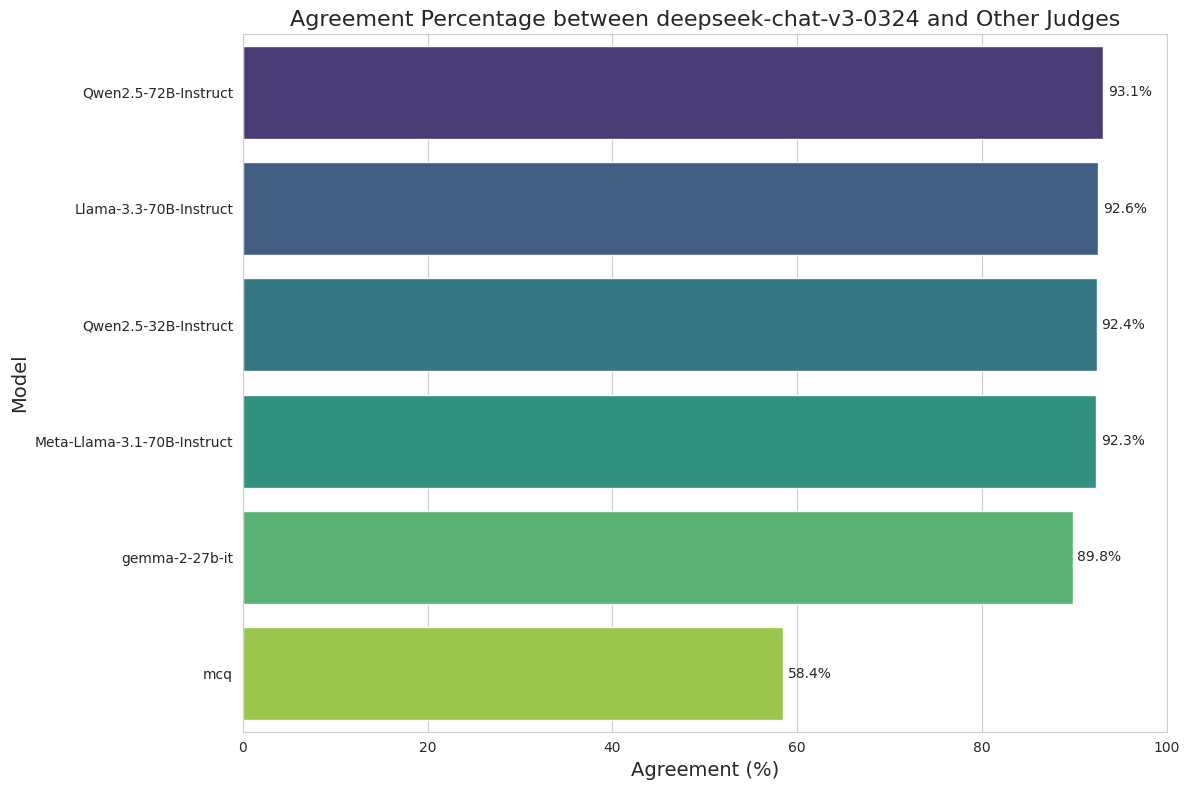

Agreement percentages with deepseek-chat-v3-0324:
Qwen2.5-72B-Instruct: 93.14%
Llama-3.3-70B-Instruct: 92.56%
Qwen2.5-32B-Instruct: 92.42%
Meta-Llama-3.1-70B-Instruct: 92.34%
gemma-2-27b-it: 89.83%
mcq: 58.44%
